Dataset from: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE203097

In [2]:
# Loading the packages

!pip install scanpy
!pip install harmonypy
!pip install leidenalg

# Dowload the data

!wget ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM6153nnn/GSM6153750/suppl/GSM6153750%5Fag%5Fmale%5Fbarcodes%2Etsv%2Egz
!wget ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM6153nnn/GSM6153750/suppl/GSM6153750%5Fag%5Fmale%5Ffeatures%2Etsv%2Egz
!wget ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM6153nnn/GSM6153750/suppl/GSM6153750%5Fag%5Fmale%5Fmatrix%2Emtx%2Egz

!wget ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM6153nnn/GSM6153751/suppl/GSM6153751%5Fag%5Ffemelle%5Fbarcodes%2Etsv%2Egz
!wget ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM6153nnn/GSM6153751/suppl/GSM6153751%5Fag%5Ffemelle%5Ffeatures%2Etsv%2Egz
!wget ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM6153nnn/GSM6153751/suppl/GSM6153751%5Fag%5Ffemelle%5Fmatrix%2Emtx%2Egz



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2023-05-25 17:49:53--  ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM6153nnn/GSM6153750/suppl/GSM6153750%5Fag%5Fmale%5Fbarcodes%2Etsv%2Egz
           => ‘GSM6153750_ag_male_barcodes.tsv.gz’
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 165.112.9.230, 130.14.250.11, 2607:f220:41e:250::7, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|165.112.9.230|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /geo/samples/GSM6153nnn/GSM6153750/suppl ... done.
==> SIZE GSM6153750_ag_male_barcodes.tsv.gz ... 12859
==> PASV ... done.    ==> RETR GSM6153750_ag_male_barcodes.tsv.gz ... done.
Length: 12859 (13K

In [3]:
# Import pakages

import os
import scanpy as sc
import scanpy.external as sce

In [ ]:
# Small organization process

os.mkdir('Female')
os.mkdir('Male')

os.replace("GSM6153750_ag_male_barcodes.tsv.gz", "Male/GSM6153750_ag_male_barcodes.tsv.gz")
os.replace("GSM6153750_ag_male_features.tsv.gz", "Male/GSM6153750_ag_male_features.tsv.gz")
os.replace("GSM6153750_ag_male_matrix.tsv.gz", "Male/GSM6153750_ag_male_matrix.tsv.gz")

os.replace("GSM6153751_ag_femelle_barcodes.tsv.gz", "Female/GSM6153751_ag_femelle_barcodes.tsv.g")
os.replace("GSM6153751_ag_femelle_features.tsv.gz", "Female/GSM6153751_ag_femelle_features.tsv.gz")
os.replace("GSM6153751_ag_femelle_matrix.tsv.gz", "Female/GSM6153751_ag_femelle_matrix.tsv.gz")


In [8]:
# Load UMI raw matrices to anndata objects

data1 = sc.read_10x_mtx(path='Male', prefix='GSM6153750_ag_male_')
data2 = sc.read_10x_mtx(path='Female', prefix='GSM6153751_ag_femelle_')

In [9]:
# Merge two datasets together

adata = data1.concatenate(data2, batch_key='Sample')

# Rename batch categories

adata.obs.Sample = adata.obs.Sample.astype("category")
adata.rename_categories('Sample', ['Male', 'Female'])

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [10]:
# Let's calculate quality metrics

adata.var['ml'] = adata.var_names.str.startswith('ml-')  # annotate the group of male as ml
sc.pp.calculate_qc_metrics(adata, qc_vars=['ml'], percent_top=None, log1p=False, inplace=True)

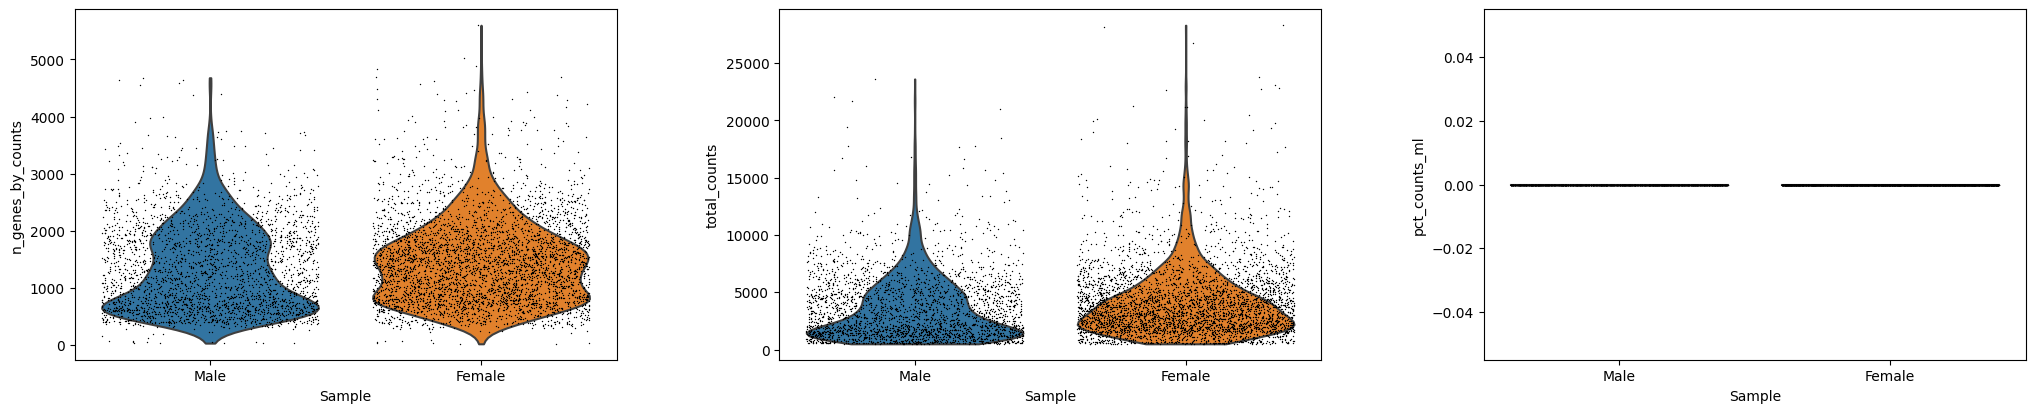

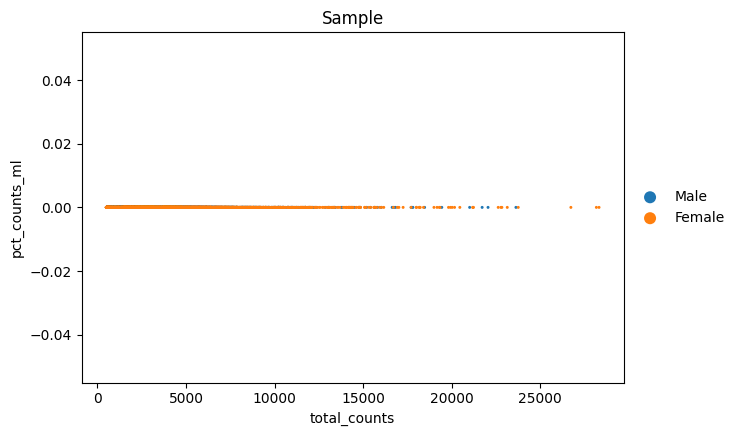

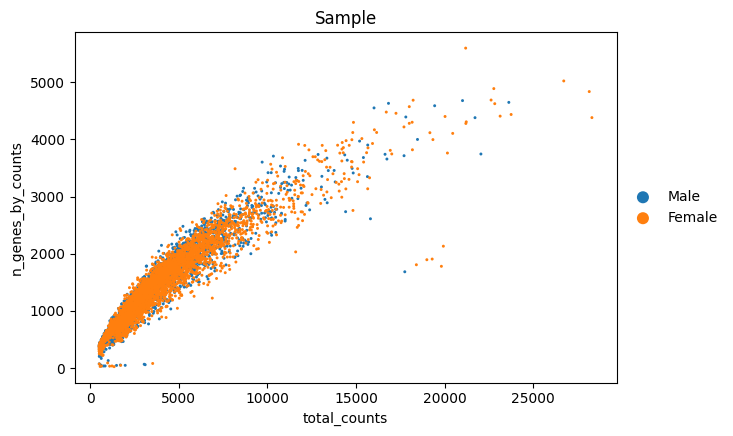

In [11]:
# And look at them

sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_ml'], jitter=0.4, multi_panel=True, groupby='Sample')

sc.pl.scatter(adata, x='total_counts', y='pct_counts_ml', color='Sample', )
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='Sample')

**What thresholds you would choose to remove doublet cells?**

In [13]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_cells(adata, max_counts=10000)
sc.pp.filter_genes(adata, min_cells=25)

adata = adata[adata.obs.pct_counts_ml < 15, :]

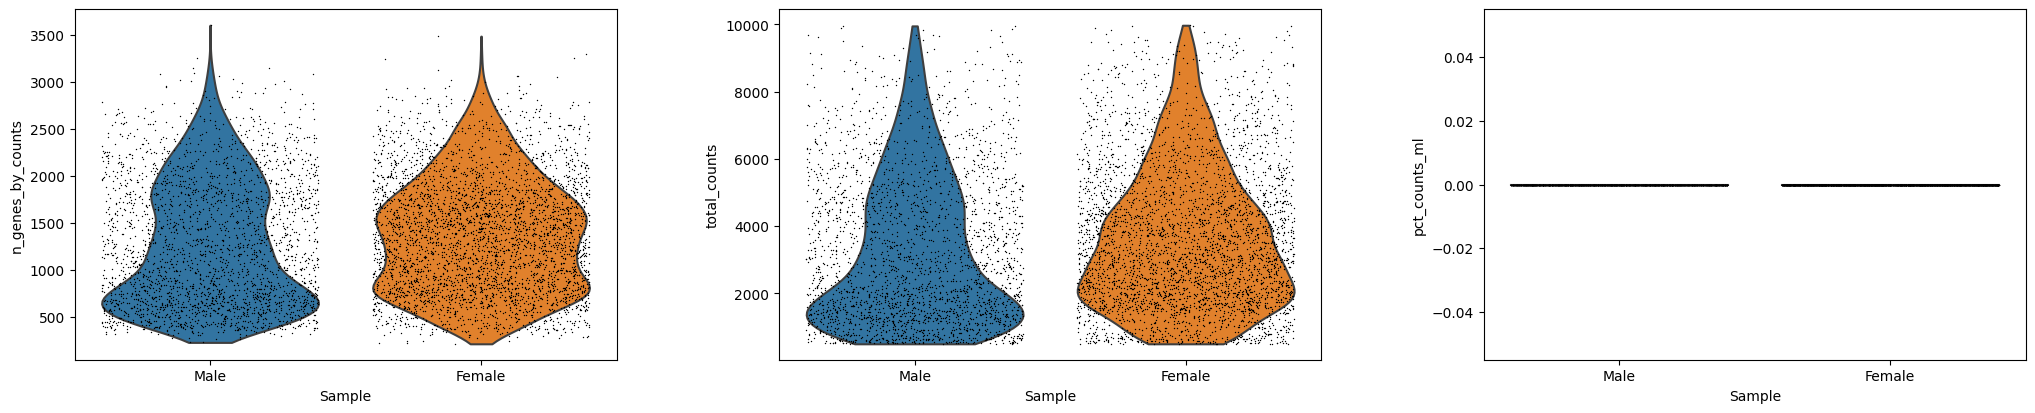

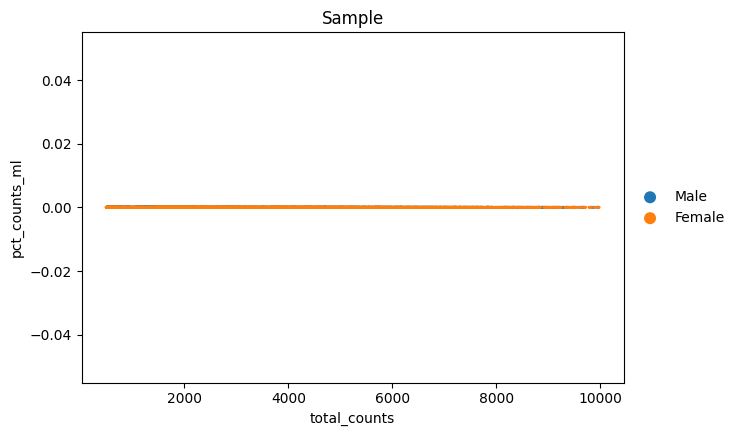

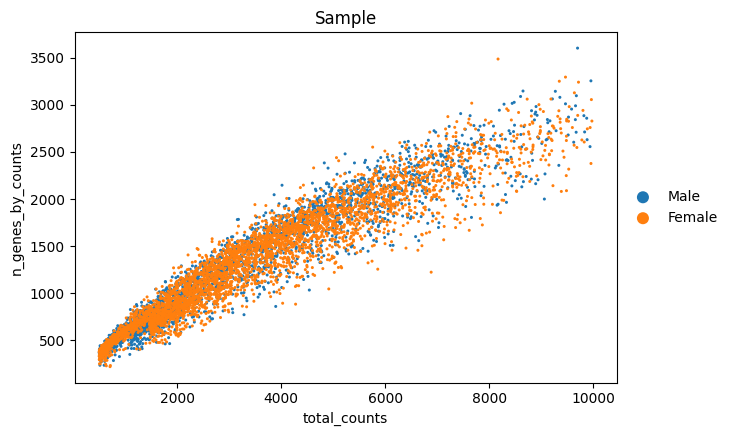

In [14]:
# Look after filtering

sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_ml'], jitter=0.4, multi_panel=True, groupby='Sample')

sc.pl.scatter(adata, x='total_counts', y='pct_counts_ml', color='Sample')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='Sample')

In [15]:
# Normalizing the data

sc.pp.normalize_total(adata, target_sum=1e4)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [16]:
sc.pp.log1p(adata)

In [17]:
# Choosing HVGs

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

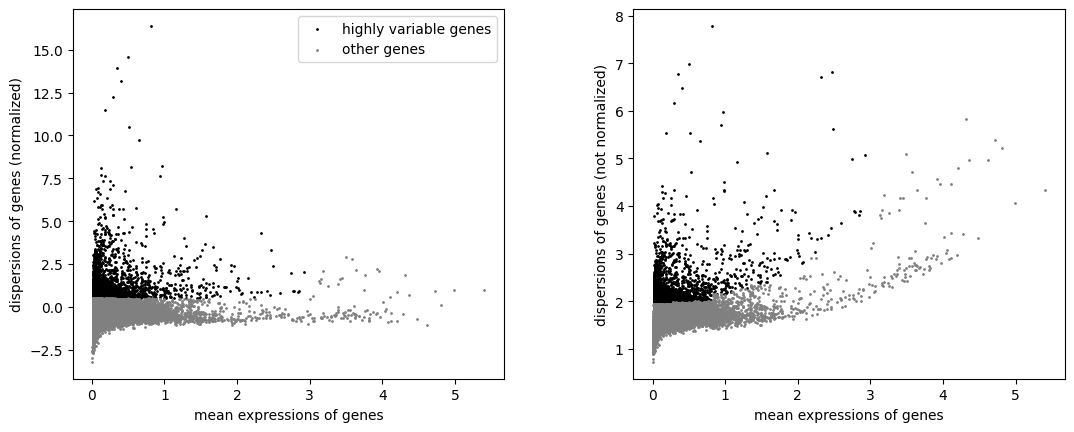

In [18]:

sc.pl.highly_variable_genes(adata)

In [19]:
#exact number of HVGs that I have in the data

adata.var.highly_variable.value_counts()

False    9813
True     2462
Name: highly_variable, dtype: int64

In [20]:
# Saving normalized data before subset

adata.raw = adata

In [21]:
# Subset only HVGs for dim reduction

adata = adata[:, adata.var.highly_variable]

In [22]:
# Scaling the data (Z-score normalization)

sc.pp.scale(adata, max_value=10)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [23]:
# PCA 

sc.tl.pca(adata)

In [24]:
# use the scanpy external to integrate the samples

sce.pp.harmony_integrate(adata, key='Sample', max_iter_harmony = 20)

2023-05-25 18:11:18,486 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2023-05-25 18:11:23,537 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2023-05-25 18:11:23,692 - harmonypy - INFO - Iteration 1 of 20
INFO:harmonypy:Iteration 1 of 20
2023-05-25 18:11:29,758 - harmonypy - INFO - Iteration 2 of 20
INFO:harmonypy:Iteration 2 of 20
2023-05-25 18:11:32,084 - harmonypy - INFO - Iteration 3 of 20
INFO:harmonypy:Iteration 3 of 20
2023-05-25 18:11:34,323 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


In [25]:
adata.obsm['X_pca'] = adata.obsm['X_pca_harmony']

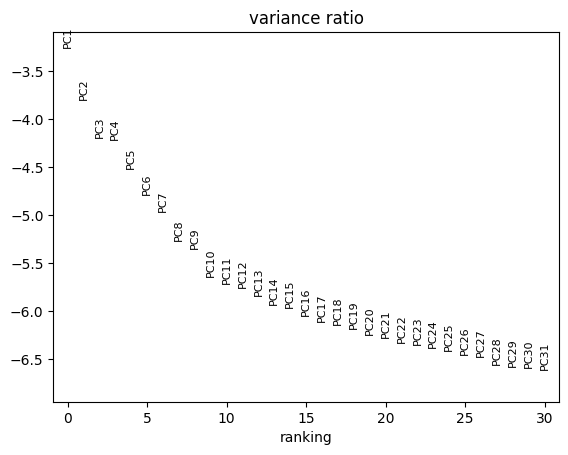

In [26]:
# Elbow plot to choose number of PCs for UMAP

sc.pl.pca_variance_ratio(adata, log=True)

In [27]:
# Building the UMAP (2 steps)

sc.pp.neighbors(adata, n_pcs=20, metric='cosine')

In [28]:
sc.tl.umap(adata)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


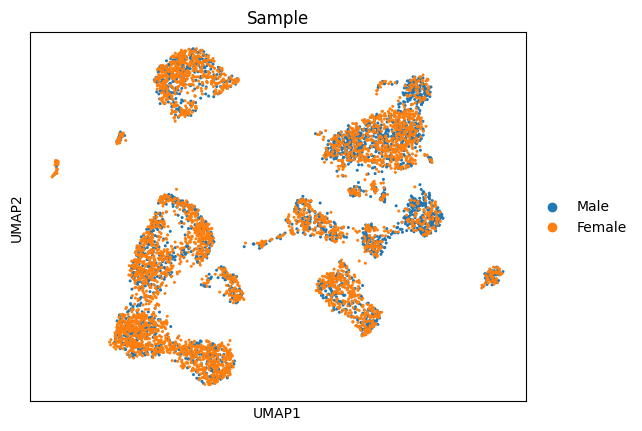

In [29]:
sc.pl.umap(adata, color=['Sample'])

In [30]:
# cluster the data

sc.tl.leiden(adata,  resolution=0.5)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


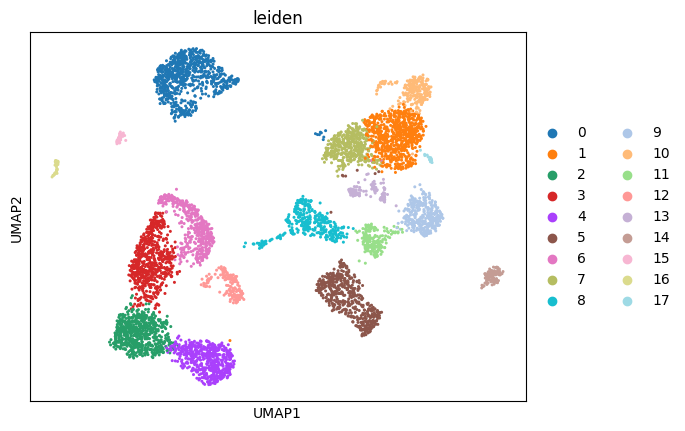

In [31]:
#look at the clusters

sc.pl.umap(adata, color=['leiden'])

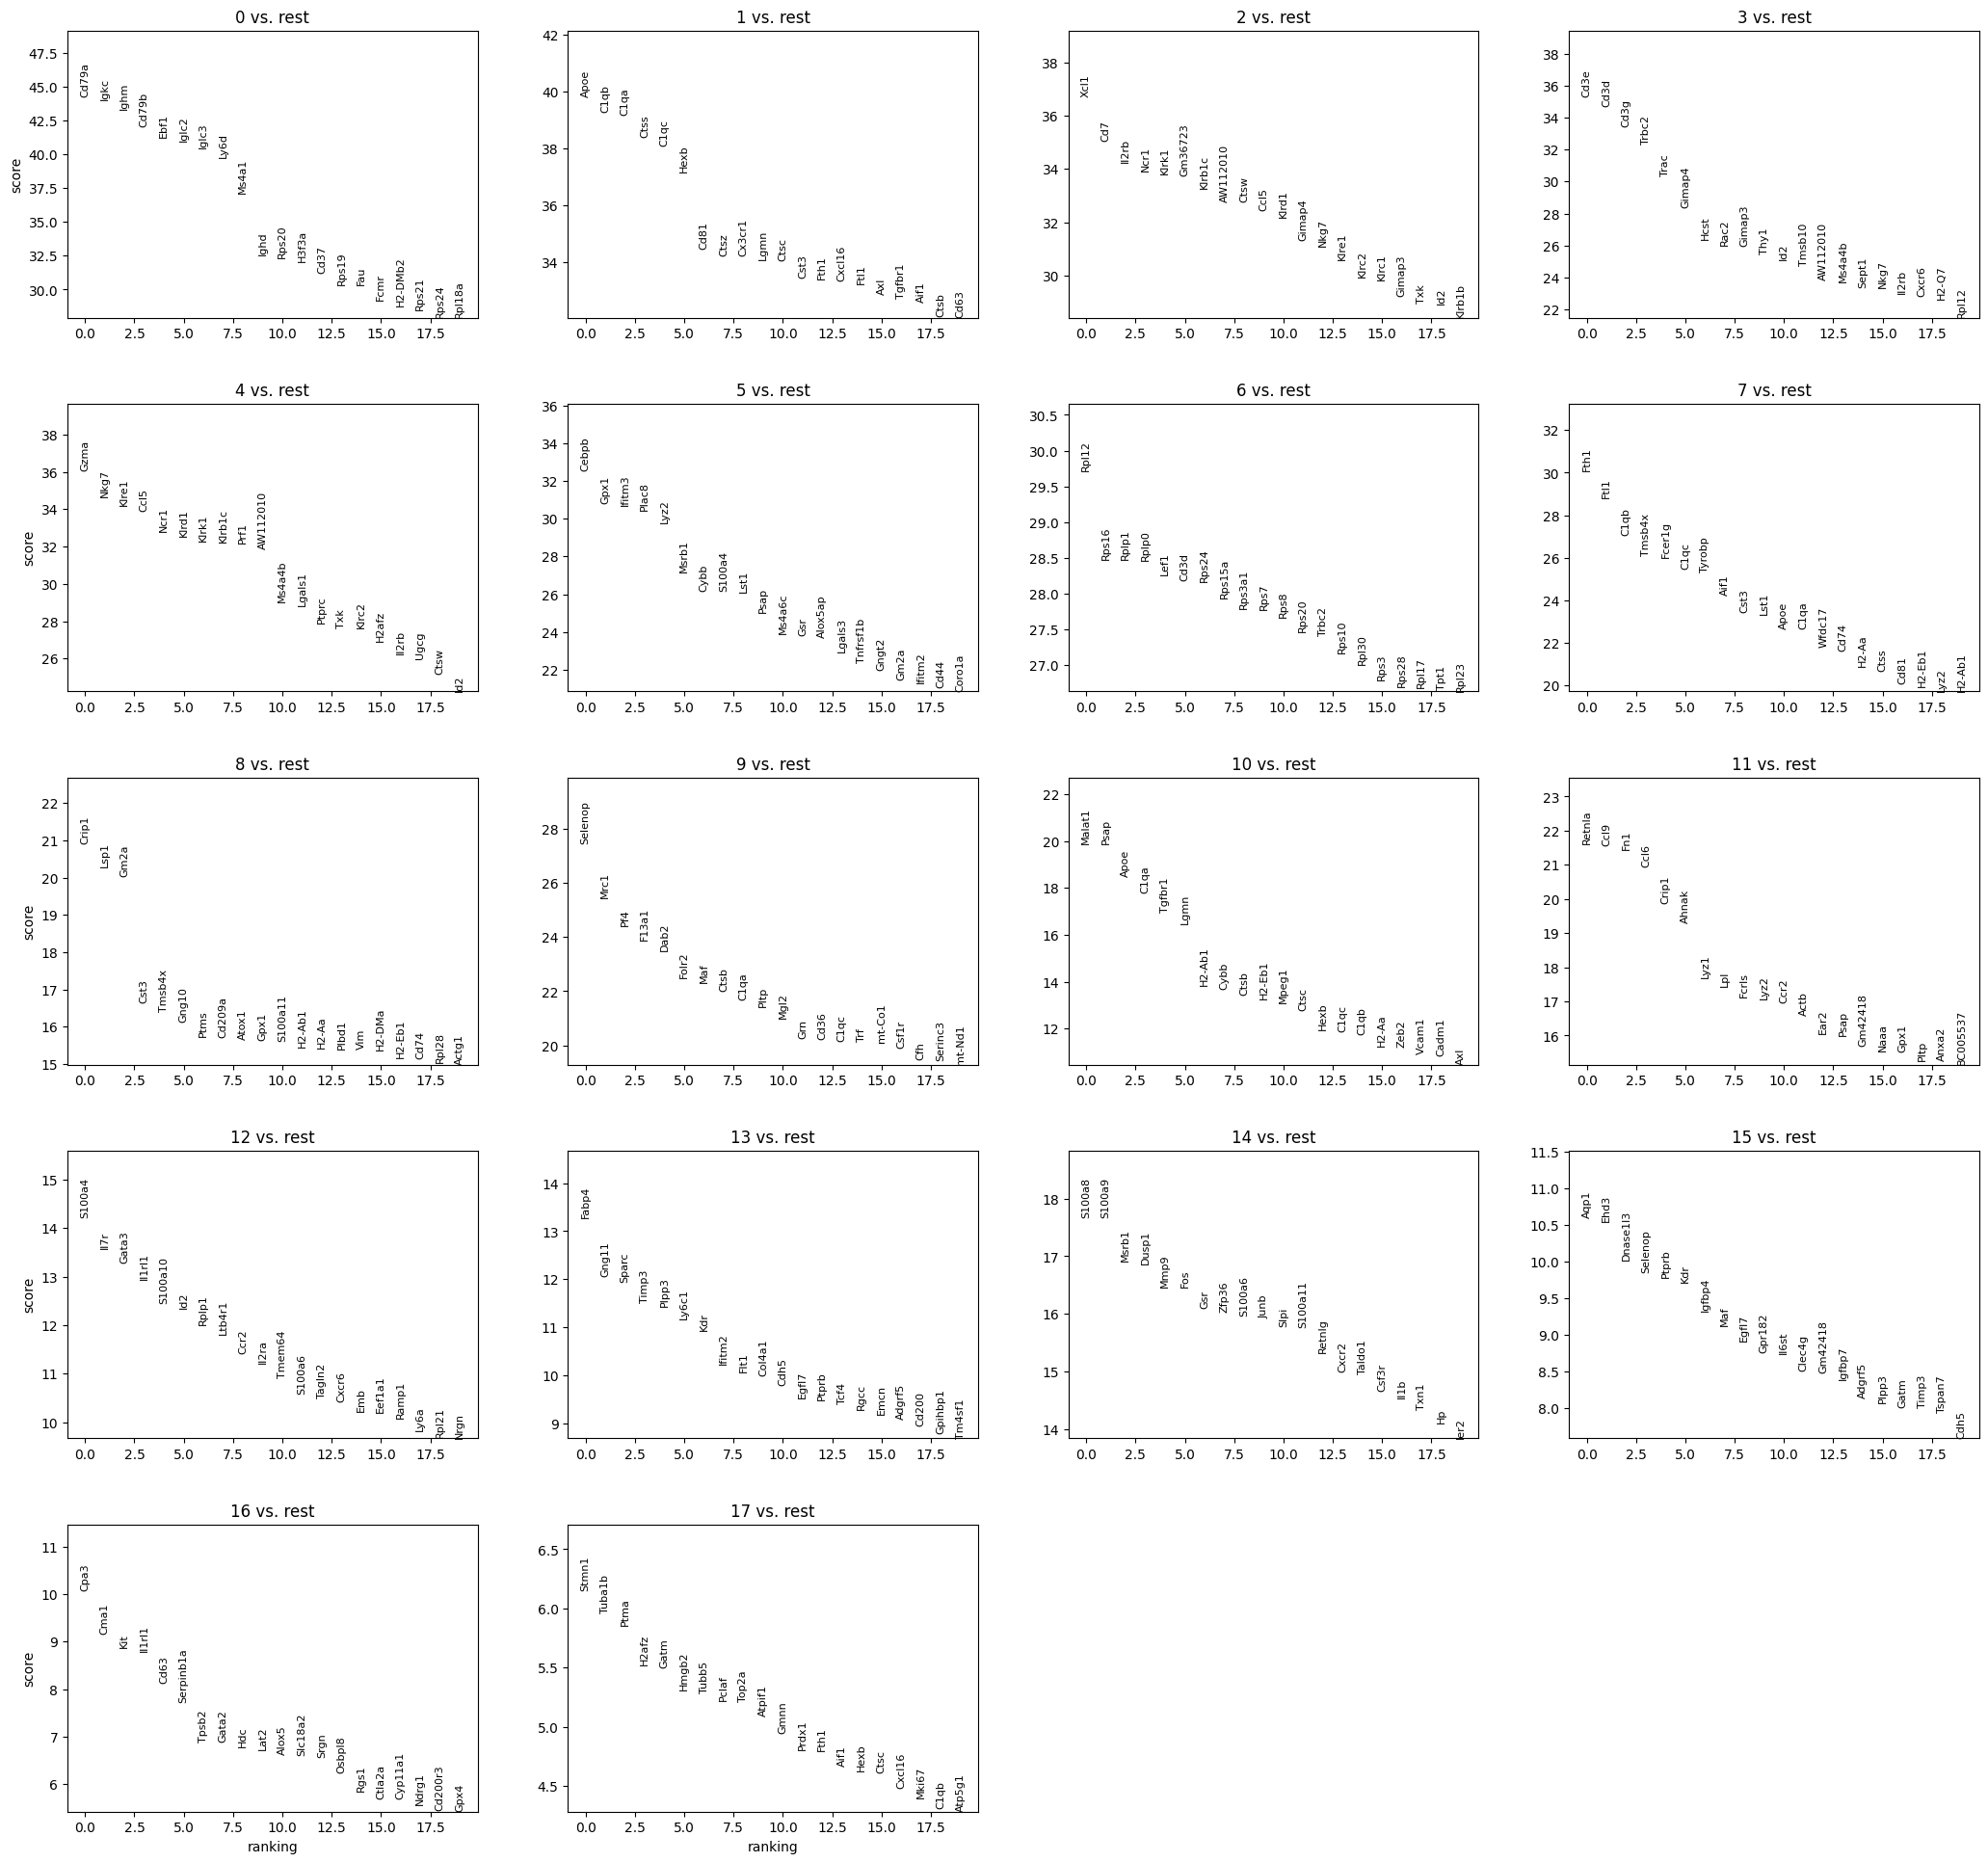

In [32]:
# Differential expression between the clusters

sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

In [33]:
sc.get.rank_genes_groups_df(adata, group=['10']).head(n=10)

,names,scores,logfoldchanges,pvals,pvals_adj
0,Malat1,19.878077,3.155208,6.300407e-88,2.148264e-85
1,Psap,19.870476,3.347975,7.330574e-88,2.431968e-85
2,Apoe,18.472509,4.192242,3.437247e-76,6.392758e-74
3,C1qa,17.784733,4.005198,9.280573e-71,1.627415e-68
4,Tgfbr1,16.949989,4.063230,1.924899e-64,2.990903e-62
5,Lgmn,16.460918,3.439908,7.002932e-61,9.995464e-59
6,H2-Ab1,13.863553,2.798291,1.053283e-43,1.010836e-41
7,Cybb,13.671608,2.628672,1.500428e-42,1.354246e-40
8,Ctsb,13.447600,2.436139,3.180272e-41,2.729919e-39
9,H2-Eb1,13.251854,2.703870,4.401907e-40,3.626403e-38


Check CD45+ markers

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


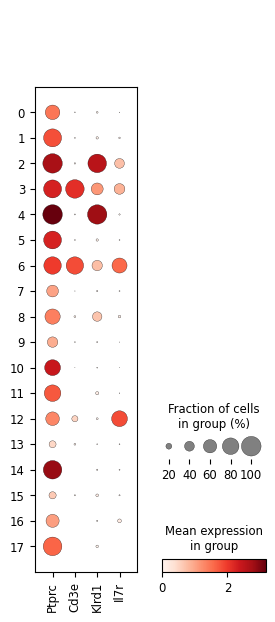

In [34]:
marker_genes = ['Ptprc', 'Cd3e', 'Klrd1', 'Il7r']
sc.pl.dotplot(adata, marker_genes, groupby='leiden')

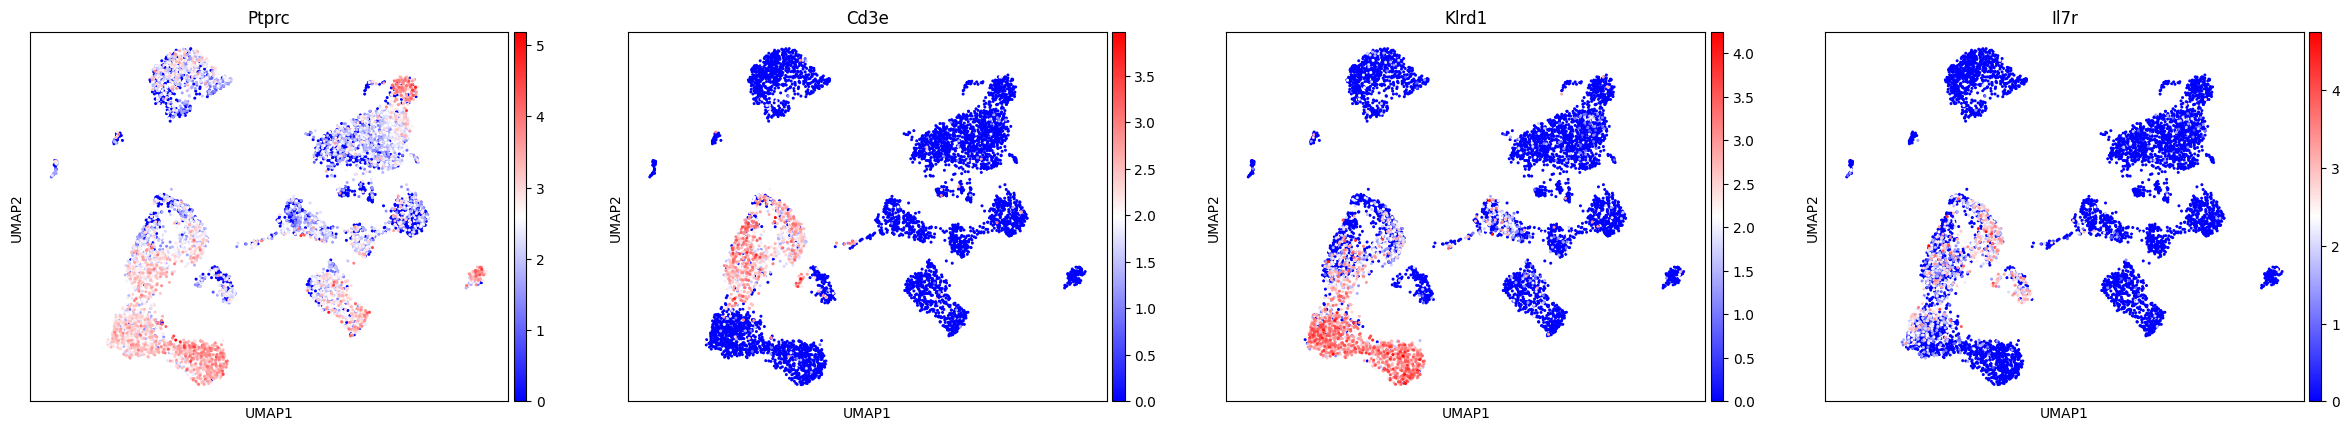

In [46]:
sc.pl.umap(adata, color=['Ptprc', 'Cd3e', 'Klrd1', 'Il7r'], color_map='bwr')

Let's look at the markers from paper:


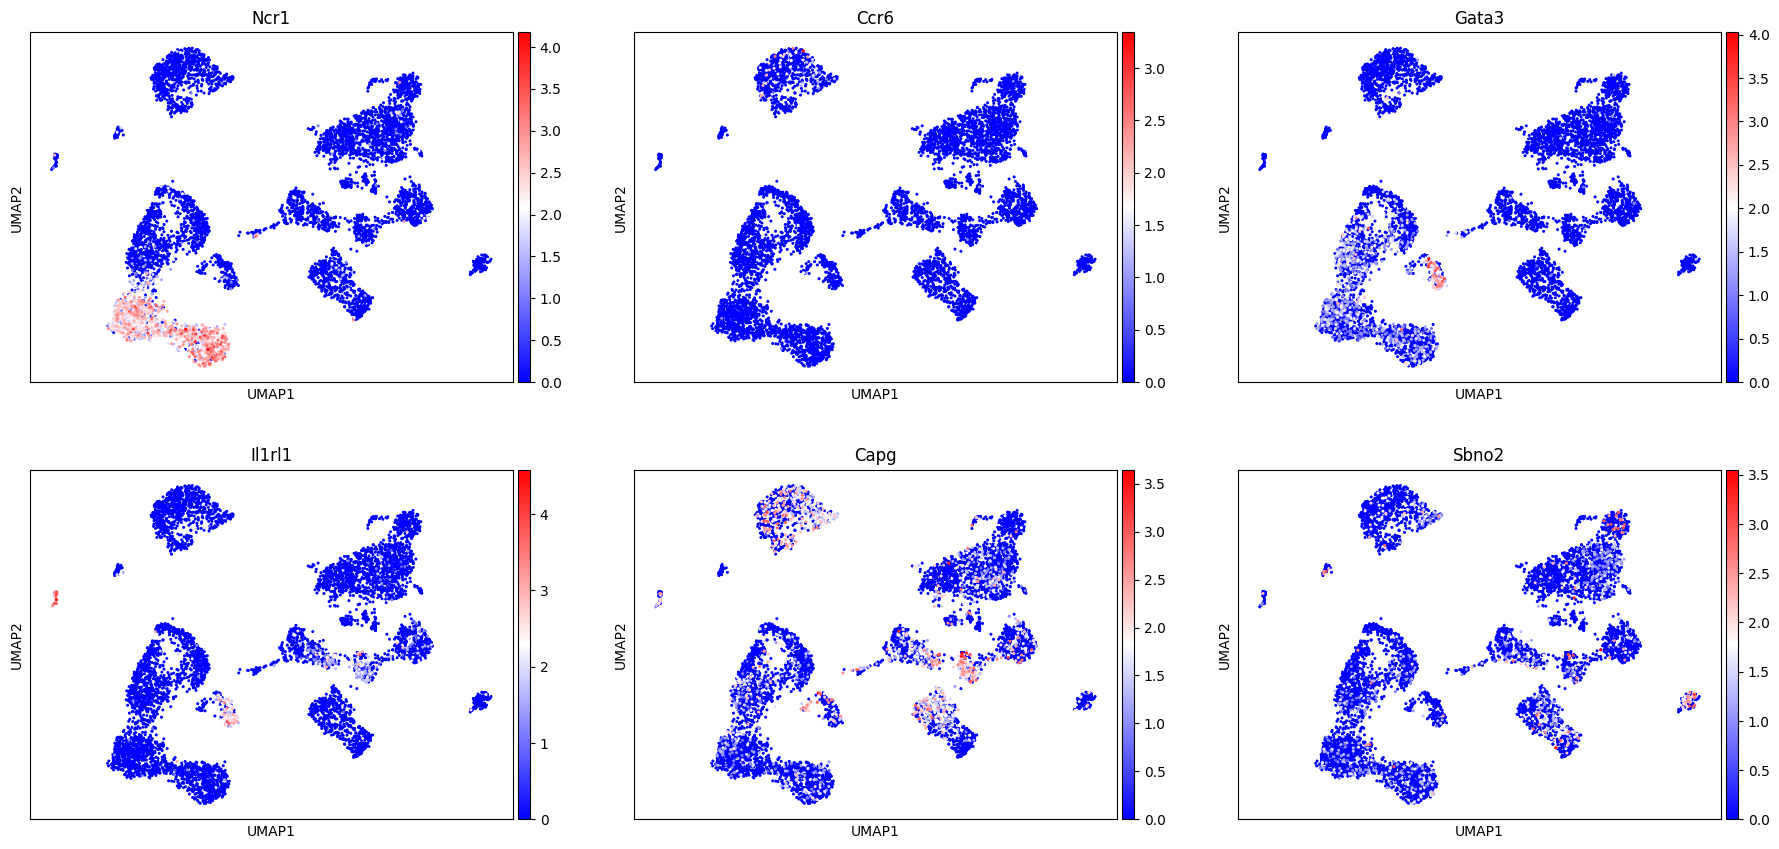

In [40]:
sc.pl.umap(adata, color=['Lyz2','Itgam','Fcgr1','Adgre1'], color_map='bwr', ncols=3)